In [29]:
# package imports
#basics
import os
import numpy as np
import pandas as pd

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation



# https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets/notebook
# import plotly as py

init_notebook_mode(connected=True) #do not miss this line

from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing every dataset
business=pd.read_csv("./yelp_business.csv")
business_attributes=pd.read_csv("./yelp_business_attributes.csv")
# business_hours=pd.read_csv("./yelp_business_hours.csv")
# check_in=pd.read_csv("./yelp_checkin.csv")
reviews=pd.read_csv("./yelp_review.csv")
tip=pd.read_csv("./yelp_tip.csv")
# user=pd.read_csv("./yelp_user.csv")
end_time=time.time()
print("Took",end_time-start_time,"s")

Took 68.02319669723511 s


In [3]:
reviews = reviews.merge(business, on='business_id')
Bacchanal = reviews[reviews['name'] == '"Bacchanal Buffet"']

In [6]:
Bacchanal.shape

(7006, 21)

In [5]:
all_words = Bacchanal['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Bacchanal Reviews'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

(-0.5, 989.5, 989.5, -0.5)

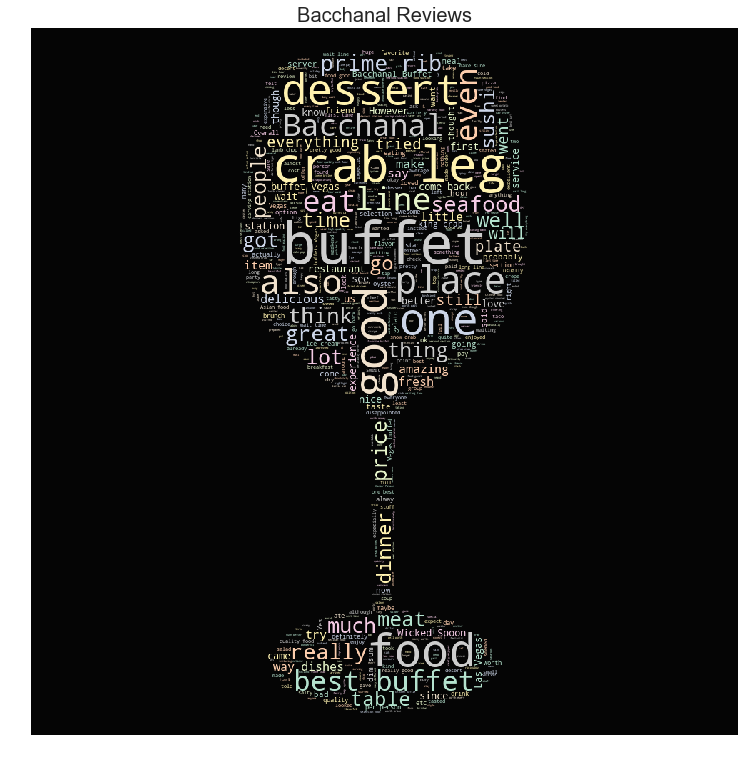

In [20]:
from wordcloud import WordCloud, STOPWORDS

img1 = imread("glass-1.png")
hcmask = img1

# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(13, 13))
wc = WordCloud(background_color="black", max_words=10000, mask=hcmask, 
               stopwords=STOPWORDS, max_font_size= 80)
wc.generate(" ".join(Bacchanal['text'].values))
plt.title("Bacchanal Reviews", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=20), alpha=0.98)
plt.axis('off')

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer

# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
        
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [25]:
# Storing the entire training text in a list
text = list(Bacchanal.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [26]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [57]:
lda = LatentDirichletAllocation(n_components=5, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [58]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:buffet food good crab dessert vega like station seafood best leg just selection great worth fresh really try meat place section rib time bacchanal dinner quality price oyster sushi asian ve variety definitely dish thing eat pretty don prime little

Topic #1:nom indulgence extraordinary carlos cranberry toasted 9am salivating 31 ease officially intense interact caramelized ing gras croissant om jaw ride stressed foie app coast foreign jd hmmm churro vince burp idiot redeeming strictly canyon saute hum luxury assure log flawless

Topic #2:le la w iron cast da directly est skillet julie clothes et attempted pa bb los en buffet und die e man image que downer tout 00am collection luxor marketing ne washed prep zu upped mesa im skipping el angeles

Topic #3:com http yelp select www biz_photos bacchanal god la resducs7fiiihp38 d6_6g roman photo pant bacchus wild silverware excess firm feast indulged drunken broke daily gut 000 celebration recipe west brag venu

In [36]:
Bacchanal = Bacchanal.reset_index(drop=True)

In [31]:
from nltk.corpus import stopwords
from string import punctuation

In [40]:
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\Dyn\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [37]:
corpus=[]
a=[]
for i in range(len(Bacchanal['text'])):
        a=Bacchanal['text'][i]
        corpus.append(a)
        

# remove common words and tokenize
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

In [38]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference
#print(dictionary)

2018-04-26 14:40:45,310 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-26 14:40:46,134 : INFO : built Dictionary(44036 unique tokens: ['$22', '$83', '(each)', '(the', '-flavor.']...) from 7006 documents (total 573227 corpus positions)
2018-04-26 14:40:46,135 : INFO : saving Dictionary object under C:\Users\Dyn\AppData\Local\Temp\elon.dict, separately None
2018-04-26 14:40:46,160 : INFO : saved C:\Users\Dyn\AppData\Local\Temp\elon.dict


In [39]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use

2018-04-26 14:40:53,116 : INFO : storing corpus in Matrix Market format to C:\Users\Dyn\AppData\Local\Temp\elon.mm
2018-04-26 14:40:53,119 : INFO : saving sparse matrix to C:\Users\Dyn\AppData\Local\Temp\elon.mm
2018-04-26 14:40:53,120 : INFO : PROGRESS: saving document #0
2018-04-26 14:40:53,236 : INFO : PROGRESS: saving document #1000
2018-04-26 14:40:53,347 : INFO : PROGRESS: saving document #2000
2018-04-26 14:40:53,459 : INFO : PROGRESS: saving document #3000
2018-04-26 14:40:53,573 : INFO : PROGRESS: saving document #4000
2018-04-26 14:40:53,685 : INFO : PROGRESS: saving document #5000
2018-04-26 14:40:53,804 : INFO : PROGRESS: saving document #6000
2018-04-26 14:40:53,917 : INFO : PROGRESS: saving document #7000
2018-04-26 14:40:53,919 : INFO : saved 7006x44036 matrix, density=0.163% (503760/308516216)
2018-04-26 14:40:53,925 : INFO : saving MmCorpus index to C:\Users\Dyn\AppData\Local\Temp\elon.mm.index


In [41]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2018-04-26 14:41:08,537 : INFO : collecting document frequencies
2018-04-26 14:41:08,539 : INFO : PROGRESS: processing document #0
2018-04-26 14:41:08,684 : INFO : calculating IDF weights for 7006 documents and 44035 features (503760 matrix non-zeros)


In [42]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [59]:
total_topics = 5

In [60]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2018-04-26 14:52:18,173 : INFO : using symmetric alpha at 0.2
2018-04-26 14:52:18,174 : INFO : using symmetric eta at 0.2
2018-04-26 14:52:18,182 : INFO : using serial LDA version on this node
2018-04-26 14:52:19,327 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 7006 documents, updating model once every 2000 documents, evaluating perplexity every 7006 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-26 14:52:19,328 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-04-26 14:52:19,329 : INFO : PROGRESS: pass 0, at document #2000/7006
2018-04-26 14:52:23,218 : INFO : merging changes from 2000 documents into a model of 7006 documents
2018-04-26 14:52:23,592 : INFO : topic #0 (0.200): 0.013*"buffet" + 0.011*"food" + 0.008*"get" + 0.006*"crab" + 0.006*"good" + 0.005*"line" + 0.005*"would" + 0.005*"time" + 0.005*"go" + 0.005*"lik

In [61]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.015*"buffet" + 0.013*"food" + 0.008*"get" + 0.007*"good" + 0.007*"line"'),
 (1,
  '0.014*"food" + 0.010*"buffet" + 0.007*"like" + 0.006*"really" + 0.005*"get"'),
 (2,
  '0.011*"buffet" + 0.009*"crab" + 0.009*"food" + 0.007*"get" + 0.005*"wait"'),
 (3,
  '0.009*"buffet" + 0.006*"like" + 0.006*"crab" + 0.005*"good" + 0.005*"food"'),
 (4,
  '0.008*"line" + 0.007*"buffet" + 0.006*"wait" + 0.005*"get" + 0.004*"like"')]

In [62]:
from collections import OrderedDict

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

(38, 3)
(3, 38)


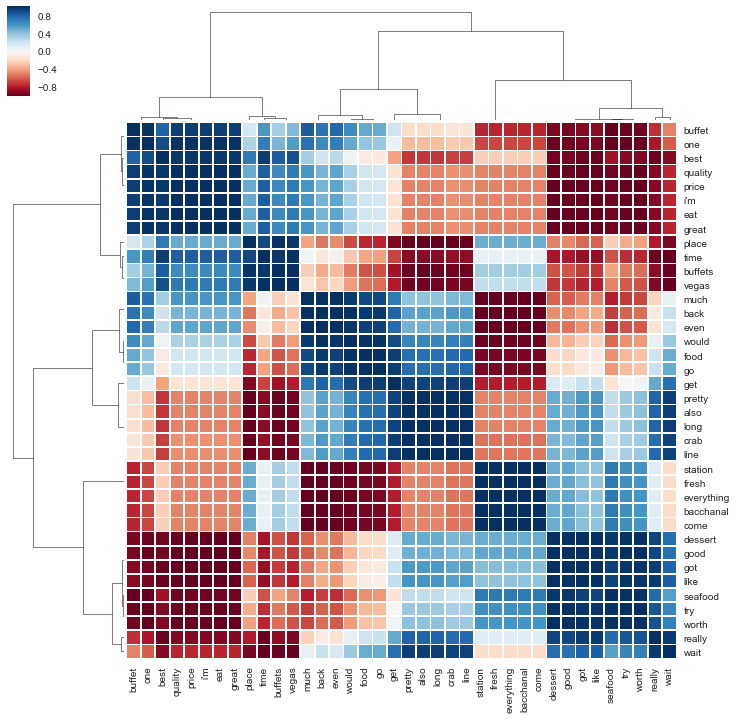

In [63]:
g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [64]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
1      59.505248        1       1  89.460243  -34.678734
3      10.219787        1       2  93.739853 -116.942986
4      10.124830        1       3   5.524873  -49.420898
0      10.077937        1       4 -16.742210 -128.482285
2      10.072197        1       5  47.148197 -184.876968, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
15    Default  73.000000     buffet  73.000000  30.0000  30.0000
30    Default  78.000000       food  78.000000  29.0000  29.0000
249   Default  35.000000       crab  35.000000  28.0000  28.0000
256   Default  29.000000       line  29.000000  27.0000  27.0000
149   Default  39.000000        get  39.000000  26.0000  26.0000
233   Default  32.000000       wait  32.000000  25.0000  25.0000
152   Default  33.000000       good  33.000000  24.0000  24.0000
223   Default  28.000000       time  28.000000  23.0000  23.0000
170   Default  42.000000       like  42.000000  22.0000  22.0000
106   Default  26.000000       best  26.000000  21.0000  21.0000
413   Default  32.000000        one  32.000000  20.0000  20.0000
237   Default  26.000000      worth  26.000000  19.0000  19.0000
81    Default  26.000000      would  26.000000  18.0000  18.0000
32    Default  25.000000         go  25.000000  17.0000  17.0000
465   Default  16.000000       back  16.000000  16.0000  16.0000
61    Default  21.000000    seafood  21.000000  15.0000  15.0000
229   Default  15.000000      vegas  15.000000  14.0000  14.0000
463   Default  20.000000       also  20.000000  13.0000  13.0000
881   Default  14.000000       legs  14.000000  12.0000  12.0000
585   Default  15.000000     dinner  15.000000  11.0000  11.0000
623   Default  19.000000        got  19.000000  10.0000  10.0000
31    Default  16.000000      fresh  16.000000   9.0000   9.0000
101   Default  19.000000  bacchanal  19.000000   8.0000   8.0000
137   Default  19.000000       even  19.000000   7.0000   7.0000
69    Default  15.000000    station  15.000000   6.0000   6.0000
701   Default  11.000000      prime  11.000000   5.0000   5.0000
183   Default  22.000000       much  22.000000   4.0000   4.0000
110   Default  17.000000    buffets  17.000000   3.0000   3.0000
116   Default  14.000000       come  14.000000   2.0000   2.0000
35    Default  18.000000      great  18.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
31     Topic5   2.407696      fresh  16.288256   0.3836  -5.6805
223    Topic5   3.372197       time  28.575924   0.1584  -5.3436
233    Topic5   3.678171       wait  32.666461   0.1115  -5.2567
30     Topic5   6.446555       food  78.569187  -0.2050  -4.6956
256    Topic5   3.409150       line  29.601914   0.1340  -5.3327
413    Topic5   3.393095        one  32.948899   0.0222  -5.3374
465    Topic5   2.163603       back  16.347045   0.2731  -5.7874
208    Topic5   0.874182       star   4.013543   0.7713  -6.6936
1006   Topic5   1.153532        rib   6.440129   0.5757  -6.4163
101    Topic5   2.177304  bacchanal  19.023153   0.1278  -5.7810
470    Topic5   1.550842      food.  10.831621   0.3517  -6.1203
1007   Topic5   1.057857       said   5.736016   0.6049  -6.5029
237    Topic5   2.543562      worth  26.089074  -0.0326  -5.6256
841    Topic5   0.975320       half   5.002464   0.6605  -6.5841
983    Topic5   1.320666       love   8.526314   0.4304  -6.2810
32     Topic5   2.415694         go  25.468052  -0.0600  -5.6771
715    Topic5   1.119135      right   6.483314   0.5387  -6.4466
78     Topic5   1.311924        two   9.271071   0.3400  -6.2876
106    Topic5   2.257075       best  26.162260  -0.1549  -5.7451
35     Topic5   1.895069      great  18.800145   0.0008  -5.9199
170    Topic5   2.742157       like  42.049360  -0.4347  -5.5504
590    Topic5   1.794103        eat  18.697916  